In [2]:
# prepare 
import numpy as np
import pylab as pb
import GPy as gpy
import matplotlib
from matplotlib import pyplot as plt
from numpy.linalg import inv
from IPython.display import display
from scipy.fftpack import fft, ifft
pb.ion()
%matplotlib inline  
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.figsize'] = (8,5)

##GP-grid trick 

We hope to calcualte the kronoker product of a series of matrices efficiently. We implemented GP-grid trick

From Gilboa et al, 
$(\bigotimes_{d=1}^DA_d)b = vec([A_1 ...[A_{D-1}[A_DB]^T]^T]^T)$

Here we want to calculate kronoker product of As, so we would like b to be identity matrix. 
The algorithm below implements "Algorithm 2" in Gilboa et al with minor modifications (i.e. in dimensions and reshapes) to accommodate b is a matrix (identity matrix), instead of a vector 

Inputs: D matrices $[A_1,A_2,...A_D]$, $A_D$ is a scaled covariance matrix in Dth dimension. Here b is calucalted inside the function. It is a N by N identity matrix, where N is product of number of elements in each dimension. 
    
Outputs: $(\bigotimes_{d=1}^DA_d)b $ = $(\bigotimes_{d=1}^DA_d)$

In [35]:
def kron_mvprod(As):
    
    # generate b 
    n = 1
    for i in np.arange(len(As)):
        n = n * As[i].shape[0]
    b = np.identity(n)
    
    x = b
    for d in np.arange(len(As)-1,-1,-1):
        Gd = As[d].shape[0]
        N = x.size
        X = np.matrix(x.reshape(Gd,N/Gd,order='F'))
        Z = As[d]*X
        Z = Z.T
        x = Z.reshape(Z.size/b.shape[1],b.shape[1],order='F') 
        
    out = x.T
    return out;


In [36]:
# test above algorithm
A1 =  np.matrix([[1, 2], [3, 4]])
A2 =  np.matrix([[5,6,7], [8,9,10],[11,12,13]])
A3 =  np.matrix([[5,2], [6,4]])
As = [A1,A2,A3]
N = A1.shape[0]* A2.shape[0]* A3.shape[0]


# confirm the algorithm: out1==out2
 
out1 = kron_mvprod(As) # use GP-grid trick 
out2 = np.kron(A1,np.kron(A2,A3)) # not use GP-grid trick 
out1-out2

matrix([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

##Part 1: Generate Data 

    Given covariance:  cov_N, cov_T, cov_C 
    i.e. cov_N is after flatterning data along the other two axis (T and C), and calculate X*X.T/(t.size*c.size)
    
    Parameters: sigma_N, sigma_T, sigma_C
    i.e. sigma_N is after flatterning data along the other two axis (T and C), and calculate X*X.T
    Requirement: tr(sigma_N) = tr(sigma_T) = tr(sigma_C)
    
    Goal: Infer U,V,W such that data generated from them having covariance cov_N, cov_T, cov_C as given


In [16]:
# number of samples
n = np.arange(0,5,1)[np.newaxis].transpose() 

# time
fs = 5.0  #  time step:1/fs
t = np.arange(0,5,1/fs)[np.newaxis].transpose()
t.size

# number of cancer types
c = np.arange(0,6,1)[np.newaxis].transpose() 
float(t.size * c.size-1)

149.0

In [17]:
print n.size
print t.size
print c.size

5
25
6


In [18]:
# Given covariance matrix 
# Requirement: tr(sigma_N) = tr(sigma_T) = tr(sigma_C)

# sigma_N: covariance along N
k1 = gpy.kern.RBF(1, variance=0.2, lengthscale=1)
cov_N = k1.K(n) #given covariance, ground truth
sigma_N = cov_N * float(t.size * c.size-1)
print np.matrix.trace(sigma_N)

# sigma_T: covariance along T
k2 = gpy.kern.RBF(1, variance=0.2 * n.size * float(t.size * c.size-1)/(t.size*float(n.size*c.size-1)), lengthscale=2)
cov_T = k2.K(t) #given covariance, ground truth
sigma_T = cov_T * float(n.size*c.size-1)
print np.matrix.trace(sigma_T)

# sigma_C: covariance along C
k3 = gpy.kern.RBF(1, variance=0.2 * n.size * float(t.size * c.size-1)/(c.size*float(t.size*n.size-1)), lengthscale=1)
cov_C = k3.K(c) #given covariance, ground truth
sigma_C = cov_C * float(t.size*n.size-1)
print np.matrix.trace(sigma_C)

149.0
149.0
149.0


##Part 2: Infer U,V,W

    U/tr(U) = sigma_N/tr(sigma_N)

    V/tr(V) = sigma_T/tr(sigma_T)

    W/tr(W) = sigma_C/tr(sigma_C) 

    requirements: trace of the three need to satisfy: tr(sigma_N) = tr(U) * tr(V) * tr(W) 
            


    
**Question**:
        
$x \sim N(0, U \otimes V \otimes W )$
            
$x \in R^{N * T * C}$
        
$X_N = R^{N * TC}$
   

To prove:     

$tr(\Sigma_N) = tr(U) * tr(V) * tr(W) $

**Proof**: 

We know that in two variable case, $\Sigma_N = tr(V)*U$. So in three variable setup, we have  $\Sigma_N = tr(V \otimes W) * U$

From kroneker product property, $tr(V \otimes W) = tr(V)tr(W)$, so we have $\Sigma_N = tr(V)tr(W)*U$. Take trace on both sides, 

we have $tr(\Sigma_N) = tr(U) * tr(V) * tr(W) $


In [19]:
#U = sigma_N/np.matrix.trace(sigma_N) * np.matrix.trace(sigma_N)
U = sigma_N/np.matrix.trace(sigma_N) *np.matrix.trace(sigma_N)
V = sigma_T/np.matrix.trace(sigma_N) 
W = sigma_C/np.matrix.trace(sigma_N) 

##Part 3: compare cov_N, cov_T, cov_C from data with ground truth
    
        use GP-grid trick 
        
        draw 100 times, 1000 times, 5000 times

In [37]:
# GP-grid trick
As = [W,U.T,V.T]
covariance = kron_mvprod(As)

In [38]:
# draw 100 times

x_N = 0 # estimate of sigma_N
x_T = 0 # estimate of sigma_T
x_C = 0 # estimate of sigma_C

nnn = 100

for i in xrange(1, nnn):
    
    
    x = np.random.multivariate_normal(np.zeros(t.size*n.size*c.size), covariance, 1)
    
    # reshape
    z = x.reshape(c.size,n.size,t.size)
    
    # cancer type (c), # of samples (n), time (t) 
    
    # covariance along cancer c
    nn = float(c.size)
    a = z[0,:,:].ravel()
    # flatten t, n axis
    for i in np.arange(1,nn):
        a = np.vstack((a, z[i,:,:].ravel()))
    x_C = x_C + np.cov(a)
    
 
   # covariance along number of samples n
    nn = float(n.size)
    
    b = z[:,0,:].ravel()
    # flatten t, c axis
    for i in np.arange(1,nn):
        b = np.vstack((b, z[:,i,:].ravel()))
    x_N = x_N + np.cov(b)
    
    # covariance along time (t)
    nn = float(t.size)
    d = z[:,:,0].ravel()
    # flatten n, c axis
    for i in np.arange(1,nn):
        d = np.vstack((d, z[:,:,i].ravel()))
    x_T = x_T + np.cov(d)
    
     
x_N = x_N/nnn
x_T = x_T/nnn
x_C = x_C/nnn

 C:\Users\Ruoxi\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: RuntimeWarning:covariance is not positive-semidefinite.


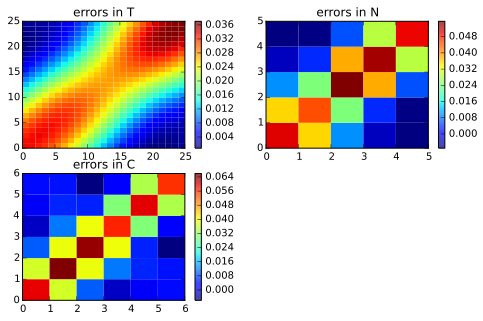

In [41]:
# Plot difference
plt.subplot(2, 2, 1)
# caovariance in T
data = cov_T - x_T
plt.pcolor(data)
plt.colorbar() 
plt.title('errors in T')

plt.subplot(2, 2, 2)
# caovariance in N
data = cov_N - x_N
plt.pcolor(data)
plt.colorbar() 
plt.title('errors in N') 

plt.subplot(2, 2, 3)
# covariance in C
data = cov_C - x_C
plt.pcolor(data)
plt.colorbar() 
plt.title('errors in C') 

plt.show()

In [42]:
# draw 1000 times

x_N = 0 # estimate of sigma_N
x_T = 0 # estimate of sigma_T
x_C = 0 # estimate of sigma_C

nnn = 1000

for i in xrange(1, nnn):
    
    
    x = np.random.multivariate_normal(np.zeros(t.size*n.size*c.size), covariance, 1)
    
    # reshape
    z = x.reshape(c.size,n.size,t.size)
    
    # cancer type (c), # of samples (n), time (t) 
    
    # covariance along cancer c
    nn = float(c.size)
    a = z[0,:,:].ravel()
    # flatten t, n axis
    for i in np.arange(1,nn):
        a = np.vstack((a, z[i,:,:].ravel()))
    x_C = x_C + np.cov(a)
    
 
   # covariance along number of samples n
    nn = float(n.size)
    
    b = z[:,0,:].ravel()
    # flatten t, c axis
    for i in np.arange(1,nn):
        b = np.vstack((b, z[:,i,:].ravel()))
    x_N = x_N + np.cov(b)
    
    # covariance along time (t)
    nn = float(t.size)
    d = z[:,:,0].ravel()
    # flatten n, c axis
    for i in np.arange(1,nn):
        d = np.vstack((d, z[:,:,i].ravel()))
    x_T = x_T + np.cov(d)
    
     
x_N = x_N/nnn
x_T = x_T/nnn
x_C = x_C/nnn

 C:\Users\Ruoxi\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: RuntimeWarning:covariance is not positive-semidefinite.


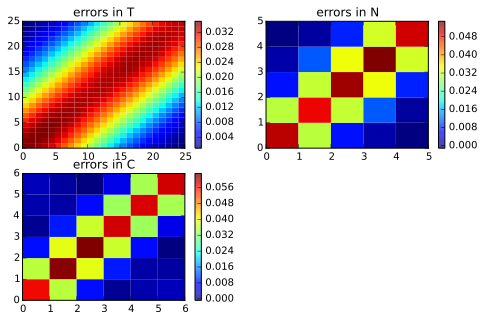

In [43]:
# Plot difference
plt.subplot(2, 2, 1)
# caovariance in T
data = cov_T - x_T
plt.pcolor(data)
plt.colorbar() 
plt.title('errors in T')

plt.subplot(2, 2, 2)
# caovariance in N
data = cov_N - x_N
plt.pcolor(data)
plt.colorbar() 
plt.title('errors in N') 

plt.subplot(2, 2, 3)
# covariance in C
data = cov_C - x_C
plt.pcolor(data)
plt.colorbar() 
plt.title('errors in C') 

plt.show()

In [47]:
# draw 5000 times

x_N = 0 # estimate of sigma_N
x_T = 0 # estimate of sigma_T
x_C = 0 # estimate of sigma_C

nnn = 5000

for i in xrange(1, nnn):
    
    
    x = np.random.multivariate_normal(np.zeros(t.size*n.size*c.size), covariance, 1)
    
    # reshape
    z = x.reshape(c.size,n.size,t.size)
    
    # cancer type (c), # of samples (n), time (t) 
    
    # covariance along cancer c
    nn = float(c.size)
    a = z[0,:,:].ravel()
    # flatten t, n axis
    for i in np.arange(1,nn):
        a = np.vstack((a, z[i,:,:].ravel()))
    x_C = x_C + np.cov(a)
    
 
   # covariance along number of samples n
    nn = float(n.size)
    
    b = z[:,0,:].ravel()
    # flatten t, c axis
    for i in np.arange(1,nn):
        b = np.vstack((b, z[:,i,:].ravel()))
    x_N = x_N + np.cov(b)
    
    # covariance along time (t)
    nn = float(t.size)
    d = z[:,:,0].ravel()
    # flatten n, c axis
    for i in np.arange(1,nn):
        d = np.vstack((d, z[:,:,i].ravel()))
    x_T = x_T + np.cov(d)
    
     
x_N = x_N/nnn
x_T = x_T/nnn
x_C = x_C/nnn

 C:\Users\Ruoxi\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: RuntimeWarning:covariance is not positive-semidefinite.


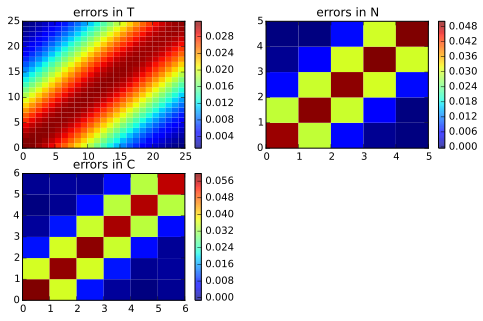

In [48]:
# Plot difference
plt.subplot(2, 2, 1)
# caovariance in T
data = cov_T - x_T
plt.pcolor(data)
plt.colorbar() 
plt.title('errors in T')

plt.subplot(2, 2, 2)
# caovariance in N
data = cov_N - x_N
plt.pcolor(data)
plt.colorbar() 
plt.title('errors in N') 

plt.subplot(2, 2, 3)
# covariance in C
data = cov_C - x_C
plt.pcolor(data)
plt.colorbar() 
plt.title('errors in C') 

plt.show()